In [1]:
# Cell: Add cumulative kms (com_kms) and update CSV in place

import pandas as pd
from pathlib import Path

# ========= CONFIG =========
CSV_PATH = Path(r"C:\Users\ishaa\OneDrive\Desktop\synthetic_data_final\synthetic_battery_inference_scenarioA.csv")
TIMESTAMP_COL = "timestamp"
OP_GAP_MINUTES = 30  # gap > this => non-operational
START_ODO_KM = 3300.0
TOTAL_GAIN_KM = 6000.0  # total kms to accumulate over all operational time
# ==========================

if not CSV_PATH.exists():
    raise FileNotFoundError(f"CSV not found: {CSV_PATH}")

print(f"Loading CSV: {CSV_PATH}")
df = pd.read_csv(CSV_PATH)

if TIMESTAMP_COL not in df.columns:
    raise ValueError(f"Timestamp column '{TIMESTAMP_COL}' not found. Available: {list(df.columns)}")

# Parse timestamps (they're already tz-aware in your file; just parse, don't localize)
df[TIMESTAMP_COL] = pd.to_datetime(df[TIMESTAMP_COL], errors="coerce")

bad_ts = df[TIMESTAMP_COL].isna().sum()
if bad_ts > 0:
    print(f"WARNING: {bad_ts} rows have invalid/NaT timestamps and will be dropped.")
    df = df.dropna(subset=[TIMESTAMP_COL])

if df.empty:
    raise ValueError("No valid timestamps left after cleaning.")

# Sort by time
df = df.sort_values(TIMESTAMP_COL).reset_index(drop=True)

# Compute time difference between consecutive rows in seconds
df["ts_diff_sec"] = df[TIMESTAMP_COL].diff().dt.total_seconds().fillna(0.0)

# Mark operational steps: gaps <= 30 minutes
gap_threshold_sec = OP_GAP_MINUTES * 60
df["is_operational_step"] = df["ts_diff_sec"] <= gap_threshold_sec

# First row has diff=0; it's fine (delta_km will be 0 there anyway)

# Total operational seconds (this matches the earlier analysis ~755,957 s)
total_op_seconds = df.loc[df["is_operational_step"], "ts_diff_sec"].sum()
print(f"Total operational seconds (measured): {total_op_seconds:.0f}")
print(f"Total operational hours: {total_op_seconds / 3600.0:.2f}")

if total_op_seconds <= 0:
    raise ValueError("No operational time detected (total_op_seconds == 0). Check timestamps and OP_GAP_MINUTES.")

# Global average speed over operational time (for sanity)
avg_speed_kmph = TOTAL_GAIN_KM / (total_op_seconds / 3600.0)
print(f"Implied average speed over operational time: {avg_speed_kmph:.2f} km/h")

# Allocate kms: constant speed across all operational time
# delta_km_i = TOTAL_GAIN_KM * (ts_diff_sec_i / total_op_seconds) for operational steps
delta_km = pd.Series(0.0, index=df.index)

op_mask = df["is_operational_step"] & (df["ts_diff_sec"] > 0)
delta_km.loc[op_mask] = TOTAL_GAIN_KM * (df.loc[op_mask, "ts_diff_sec"] / total_op_seconds)

# Cumulative kms
com_kms = START_ODO_KM + delta_km.cumsum()

# Optional drift correction to hit exactly START + TOTAL_GAIN at the last row
target_end = START_ODO_KM + TOTAL_GAIN_KM
drift = target_end - com_kms.iloc[-1]

print(f"Target end odo: {target_end:.3f} km")
print(f"Current end odo (before drift fix): {com_kms.iloc[-1]:.3f} km")
print(f"Drift to correct at last row: {drift:.6f} km")

# Apply drift only to the last row (tiny adjustment, negligible in practice)
com_kms.iloc[-1] = com_kms.iloc[-1] + drift

df["com_kms"] = com_kms

# Sanity check: monotonic non-decreasing
if (df["com_kms"].diff().dropna() < -1e-6).any():
    raise RuntimeError("com_kms is not monotonic non-decreasing; check logic.")

print(f"Final start odo: {df['com_kms'].iloc[0]:.3f} km")
print(f"Final end odo:   {df['com_kms'].iloc[-1]:.3f} km")
print(f"Total gained:    {df['com_kms'].iloc[-1] - df['com_kms'].iloc[0]:.3f} km")

# NOTE: Composite score vs distance:
# You don't need a separate column for 'x-axis as distance'.
# When plotting, just use com_kms on x-axis and your existing composite/health metric on y-axis.
# This code just checks if a column named 'composite_score' exists and logs info.

if "composite_score" in df.columns:
    print("Column 'composite_score' found. For distance-based plots, use:")
    print("  x = 'com_kms', y = 'composite_score'")
else:
    print("NOTE: Column 'composite_score' not found. Use whatever health/composite column you have vs 'com_kms'.")

# Clean up helper columns not needed in final CSV
df = df.drop(columns=["ts_diff_sec", "is_operational_step"], errors="ignore")

# Overwrite the CSV in place
df.to_csv(CSV_PATH, index=False)
print(f"\nUpdated CSV written in place with new 'com_kms' column:\n  {CSV_PATH}")


Loading CSV: C:\Users\ishaa\OneDrive\Desktop\synthetic_data_final\synthetic_battery_inference_scenarioA.csv
Total operational seconds (measured): 755957
Total operational hours: 209.99
Implied average speed over operational time: 28.57 km/h
Target end odo: 9300.000 km
Current end odo (before drift fix): 9300.000 km
Drift to correct at last row: -0.000000 km
Final start odo: 3300.000 km
Final end odo:   9300.000 km
Total gained:    6000.000 km
Column 'composite_score' found. For distance-based plots, use:
  x = 'com_kms', y = 'composite_score'

Updated CSV written in place with new 'com_kms' column:
  C:\Users\ishaa\OneDrive\Desktop\synthetic_data_final\synthetic_battery_inference_scenarioA.csv


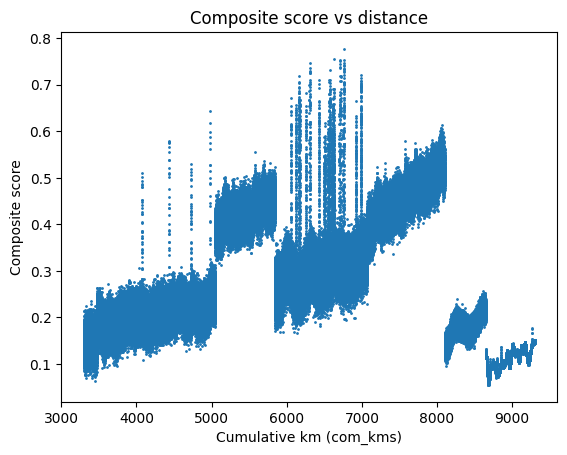

In [2]:
# Example plotting snippet (not required for CSV update)
import matplotlib.pyplot as plt

df = pd.read_csv(CSV_PATH)
plt.figure()
plt.scatter(df["com_kms"], df["composite_score"], s=1)  # or any health metric instead of composite_score
plt.xlabel("Cumulative km (com_kms)")
plt.ylabel("Composite score")
plt.title("Composite score vs distance")a
plt.show()


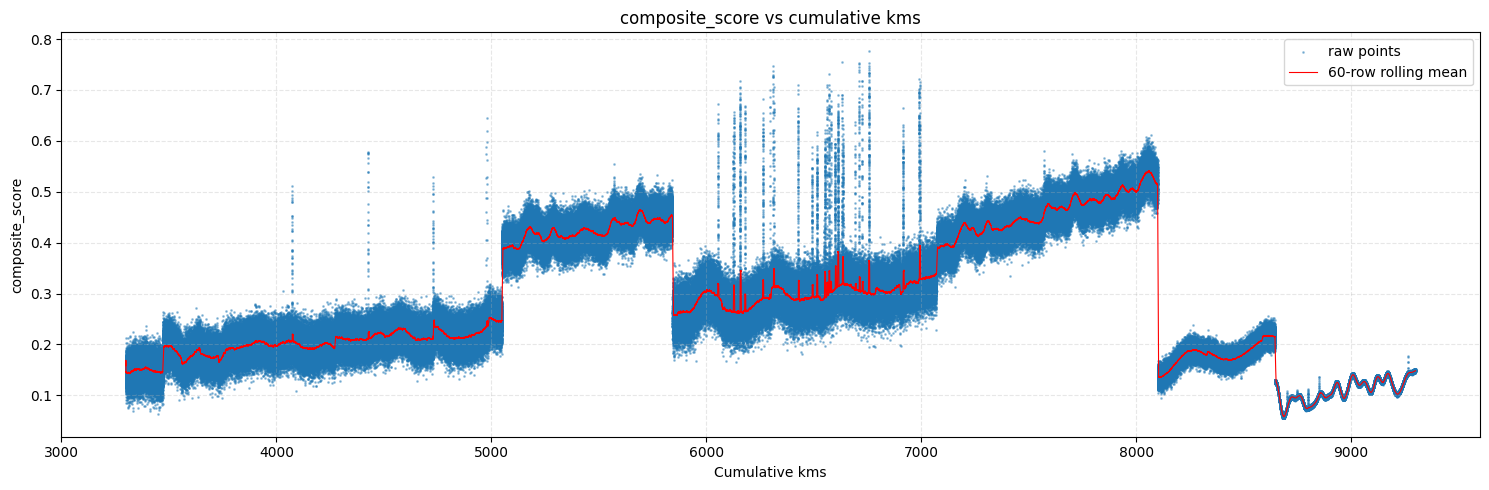

In [6]:
# Cell: Plot composite vs distance with 60-row rolling mean

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

CSV_PATH = Path(r"C:\Users\ishaa\OneDrive\Desktop\synthetic_data_final\synthetic_battery_inference_scenarioA.csv")
HEALTH_COL = "composite_score"  # change if your metric uses another name

df = pd.read_csv(CSV_PATH)

if "com_kms" not in df.columns:
    raise ValueError("Column 'com_kms' not found. Generate it first.")

if HEALTH_COL not in df.columns:
    raise ValueError(f"Health column '{HEALTH_COL}' not found in CSV.")

# Rolling mean of 60 rows over the sorted kms axis
df = df.sort_values("com_kms").reset_index(drop=True)
df["mean60"] = df[HEALTH_COL].rolling(window=600, min_periods=1).mean()

plt.figure(figsize=(15,5))
plt.scatter(df["com_kms"], df[HEALTH_COL], s=1, alpha=0.4, label="raw points")
plt.plot(df["com_kms"], df["mean60"], linewidth=0.8, label="60-row rolling mean", color="red")

plt.xlabel("Cumulative kms")
plt.ylabel(HEALTH_COL)
plt.title(f"{HEALTH_COL} vs cumulative kms")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()
